# ML Flow
## Introduction
The traditional software development vs a machine learning development are different, the paradigm is different. for many reasons:

- The metrics is what you want to optimize, you constantly experiment to improve it (vs meet a functional specification)

- The quality depends on input data and tuning parameters ( vs depend only on code).

looking at the machine learning lifecycle we can use different tools for instance for data preparation we can use spark, python or whatever, for training as well we can use very different tools like tf or torch, as well when deploying (docker, kubernetes) nd lastly also for dealing with raw data.

the two main problems when CI/CD is the **tuning parameters** and the amount of **scale** to be done to having a good ML system. 

MLflow is designed following some principles:

1. **API-First**:
    * submit runs, log models. metrics
    * abstract "model" lambda function that MLflow can then deploy in many places (Docker, Azure ML and others)
    * Open interface allows easy integration from the community.

2. **Modular Design**:
    * allow different components individually (tracking/projects/models/registry)
    * Not monolithic

We have 4 different components of ML Flow:

1. Tracking: record and query experiments: code, data, config and results
2. Projects: package data science code in a format that enables reproducible runs on many platform
3. Models: deploy machine learning modes in diverse serving environment
4. Models Registry: store, annotate and manage models in a central repository

## ML FLow Tracking
Tracking is always be done in DevOps in machine learning we have several concepts to be tracked such as:

- Parameters 
- Metrics
- Tags and notes (information about the runs)
- Artifacts (files, data, models)
- Source (code that run)
- Version
- Run: an instance of code that runs by ML flow (collects all the previous important information)
- Experiment: multiples Runs

the main idea with ml flow we can keep track of parameters very easily such as:


```py
import mlflow

with mlflow.start_run():
    mlflow.log_param()
    mlflow.log_param("data_file", data_file)
    mlflow.log_param("lr", lr)
    mlflow.log_metric("score", score)
    mlflow.sklearn.log_model(model)
```

then mlflow is able to create a very nice graphic interface to keep track of all your experiments. 

```bash
mlflow ui
```

we have producers such as notebooks or R or java that produce information, then we have a tracking server and lastly we have the final users such as UI, API and also Spark Data Source!

```
export MLFLOW_TRACKING_URI <URI>
mlflow.set_tracking_uri(URI)
```

the mlflow tracking backend stores are typically the FileStore (local filesystem) and SQLSTORE (via SQLalchemy) which could be done in MySql but also in SQLITE. also with the artifact we could use local filesystem or technologies that allows to store blob such as S3.

databricks community edition
workspace -> import or create folder


In [1]:
import pandas as pd

dataset = pd.read_csv(("https://github.com/dmatrix/tutorials/raw/master/mlflow/labs/data/airbnb-cleaned-mlflow.csv"))
dataset.head(2)

,host_total_listings_count,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,1.0,0,0,37.769310,-122.433856,0,0,3.0,1.0,1.0,...,1.0,127.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0
1,2.0,1,1,37.745112,-122.421018,0,0,5.0,1.0,2.0,...,30.0,112.0,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0


In [17]:
import os
import numpy as np
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import tempfile


class RandomForestML():
    rmse = []
    estimators = []

    def __init__(self, params={}):
        self.model = RandomForestRegressor(**params)
        self.params = params

    @classmethod
    def new_instance(cls, params={}):
        return cls(params)

    @staticmethod
    def plot_graphs(x_data, y_data, x_label, y_label, title):
        plt.clf()
        fig, ax = plt.subplots()
        ax.plot(x_data, y_data)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
        return (fig, ax)


    def preprocess_data(self, df):                
            X = df.iloc[:, 0:4].values
            y = df.iloc[:, 4].values
            return train_test_split(X, y, test_size=0.2, random_state=0)
      

    def mlflow_run(self, df, r_name="MlFlow experiment"):
        
        with mlflow.start_run(run_name=r_name) as run:
            runID = run.info.run_uuid
            experimentID = run.info.experiment_id
            
            # extract all feature independent attributes
            X_train, X_test, y_train, y_test = self.preprocess_data(df)  
            # train and predict
            self.model.fit(X_train, y_train)
            y_pred = self.model.predict(X_test)

            # Log model and params using the MLflow APIs
            mlflow.sklearn.log_model(self.model, "random-forest-reg-model")
            mlflow.log_params(self.params)

            # compute  regression evaluation metrics 
            mae = metrics.mean_absolute_error(y_test, y_pred)
            mse = metrics.mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = metrics.r2_score(y_test, y_pred)

            # Log metrics
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)

            # update global class instance variable with values
            self.rmse.append(rmse)
            self.estimators.append(self.params["n_estimators"])

            # plot graphs and save as artifacts
#             (fig, ax) = RandomForestML.plot_graphs(self.estimators, 
#                                                    self.rmse, 
#                                                    "Random Forest Estimators", 
#                                                    "Root Mean Square", 
#                                                    "Root Mean Square vs Estimators")
            
            # create temporary artifact file name and log artifact
#             temp_file_name = tempfile.NamedTemporaryFile()
#             print(temp_file_name)
#             temp_name = temp_file_name.name
#             try:
#                 fig.savefig(temp_name)

#             finally:
#                 temp_file_name.close()  # Delete the temp file
            
            return (experimentID, runID)

Experiment with the following parameters: {'n_estimators': 75, 'max_depth': 9, 'random_state': 42}
MLflow Run completed with run_id d02f0e810e004287a1194c5ab0a117d0 and experiment_id 0
----------------------------------------------------------------------------------------------------
Experiment with the following parameters: {'n_estimators': 100, 'max_depth': 4, 'random_state': 42}
MLflow Run completed with run_id 0ff19c6e59ed4e9ab48b5d070853235a and experiment_id 0
----------------------------------------------------------------------------------------------------
Experiment with the following parameters: {'n_estimators': 150, 'max_depth': 5, 'random_state': 42}
MLflow Run completed with run_id 94a0a660e4f0478a9ccb8b346b9d9efe and experiment_id 0
----------------------------------------------------------------------------------------------------
Experiment with the following parameters: {'n_estimators': 55, 'max_depth': 10, 'random_state': 42}
MLflow Run completed with run_id ae7cc50

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

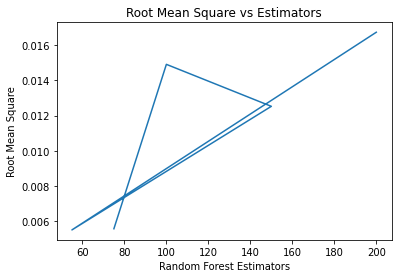

In [18]:
params_list = [ 
  {"n_estimators": 75,"max_depth": 9, "random_state": 42},
  {"n_estimators": 100,"max_depth": 4, "random_state": 42},
  {"n_estimators": 150,"max_depth": 5, "random_state": 42},
  {"n_estimators": 55,"max_depth": 10, "random_state": 42},
  {"n_estimators": 200,"max_depth": 3, "random_state": 42},
  ]


for params in params_list:
  print(f"Experiment with the following parameters: {params}")
  rfr = RandomForestML.new_instance(params)  
  experiment = f"Experiment with {params['n_estimators']} trees"
  (experimentID, runID) = rfr.mlflow_run(dataset, r_name=experiment)
  print(f"MLflow Run completed with run_id {runID} and experiment_id {experimentID}")
  print("-" * 100)

## MLFlow Projects
is useful to package and maintains the code of ML system. the motivation of MLflow project is that we have so many differs diverse tools and environments that may result in **diffuclt to reproduce experiment**

MLFlow is a self contains of all the code, dependencies, configuration and data that allow to reproduce experiments. 

MLflow is a specification that allows to perform operation such as (where we have a conda.yaml file that specifies all the necessary elements):


```bash
mlflow run git:://<my_project>.git -P lambda=0.2
```

most important is the conda.yaml file, it tells to mlflow to create the correct dependencies necessary for run the experiment. 

We can create a multi-step workflow before like training a models. we can specify steps and actions to perform when replicating the model. to do that:


```MLProject
name: tutorial

conda_env: conda.yaml

entry_points:
  main:
    parameters:
      batch_size: {type: int, default: 10}
      epochs: {type: int, default: 100}
    command: "python train_keras.py {batch_size} {epochs}"
```


```yaml
channels:
- defaults
- conda-forge
dependencies:
- python=3.7.5
- boto3
- pip
- pip:
  - mlflow
  - h5py==2.10.0
  - keras==2.3.1
  - tensorflow==2.0.0
name: mlflow-env
```

When recreating an experiment all the dependecies and version will be exactly the ones specified here!


```py
params = {'batch_size': 10,'epochs': 100}
ml_project_uri = "git://github.com/dmatrix/mlflow-workshop-project-expamle-1.git"

res_sub = mlflow.run(ml_project_uri, parameters=params)

print(f"status={res_sub.get_status()}")
print(f"run_id={res_sub.run_id}")
```

it will run that exact experiment with those parameters and dependecies!

## AutoLoG
autolog allow to track logs bery easly with torch, sklearn, tensorflow, keras.


In [ ]:
# Define the model
def baseline_model():
   model = keras.Sequential([
      keras.layers.Dense(64, activation='relu', input_shape=[1]),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(1)
   ])

   optimizer = keras.optimizers.RMSprop(0.001)

   # Compile the model
   model.compile(loss='mean_squared_error',
                 optimizer=optimizer,
                 metrics=['mean_absolute_error', 'mean_squared_error'])
   return model


def f2c(f):
  return (f - 32) * 5.0/9.0

def gen_data(start, stop, step):
    X_fahrenheit = np.arange(start, stop, step, dtype=float)
    np.random.shuffle(X_fahrenheit)
    y_celsius = np.array(np.array([f2c(f) for f in X_fahrenheit]))
    predict_data =[]
    [predict_data.append(t) for t in range (212, 170, -5)]
    
    return (X_fahrenheit, y_celsius, predict_data)

In [ ]:
def mlflow_run(params, X, y, run_name="Keras Linear Regression"):
   with mlflow.start_run(run_name=run_name) as run:
      run_id = run.info.run_uuid
      exp_id = run.info.experiment_id
      
      model = baseline_model()

      mlflow.keras.autolog()
      model.fit(X, y, batch_size=params['batch_size'], epochs=params['epochs'])

      return (exp_id, run_id)

In [ ]:
(X, y, predict_data) = gen_data(-212, 10512, 2)

params = {'batch_size': 10,'epochs': 100}
(exp_id, run_id) = mlflow_run(params, X, y)
print(f"Finished Experiment id={exp_id} and run id = {run_id}")